In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

#my functions
from utils import load_data

#go to working directory
work_dir='/mnt/Data1/ribli/mhc/'
os.chdir(work_dir)

Using Theano backend.
/mnt/Data1/ribli/tools/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
x,y=load_data(hla_representation='simple',seq_representation='simple')

Reading from file...
Creating representation...
Using  83751 data points
Done, It took: 0.700392007828 s


In [3]:
#make train, test and validation split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [4]:
import xgboost as xgb

#data format for xgb
dtrain = xgb.DMatrix( X_train, label=y_train)
dvalid = xgb.DMatrix( X_valid, label=y_valid)
dtest = xgb.DMatrix( X_test)


#model params
param = {'max_depth':9,
         'eta':0.05,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "reg:linear",
         'eval_metric': 'rmse',
         'nthread':7}

#printed evals
evallist  = [(dtrain,'train'),(dvalid,'eval')]

#lets train
num_round = 5000
bst = xgb.train(param,
                dtrain,
                evals=evallist,
                num_boost_round=num_round,
                early_stopping_rounds=100,
                verbose_eval=500)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmse:2.547578	eval-rmse:2.515731
[500]	train-rmse:0.629569	eval-rmse:0.893040
[1000]	train-rmse:0.471053	eval-rmse:0.862460
[1500]	train-rmse:0.380875	eval-rmse:0.854648
[2000]	train-rmse:0.317571	eval-rmse:0.851832
Stopping. Best iteration:
[2207]	train-rmse:0.295258	eval-rmse:0.851381



### Correlation plot

Correlation: 0.767103419717


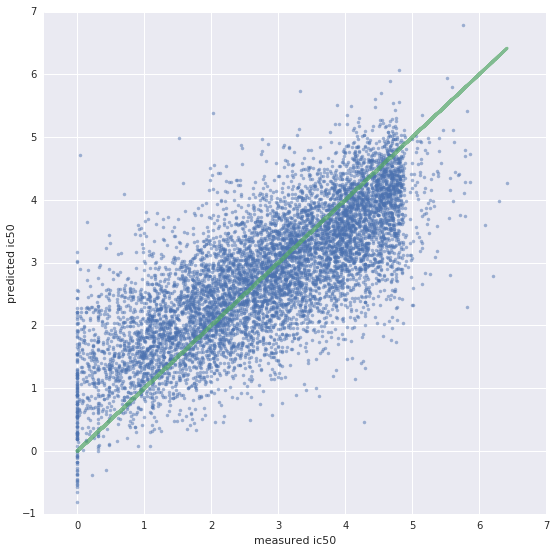

In [5]:
plt.figure(figsize=(9,9))
y_pred_test=bst.predict(dtest)
plt.plot(y_test,y_pred_test,'.',alpha=0.5)
plt.plot(y_test,y_test,lw=3,alpha=0.7)
plt.xlim(xmin=-0.5)
plt.xlabel('measured ic50')
plt.ylabel('predicted ic50')

from scipy.stats import pearsonr
print 'Correlation:',pearsonr(y_test,y_pred_test)[0]

### Error depending on the length of peptid

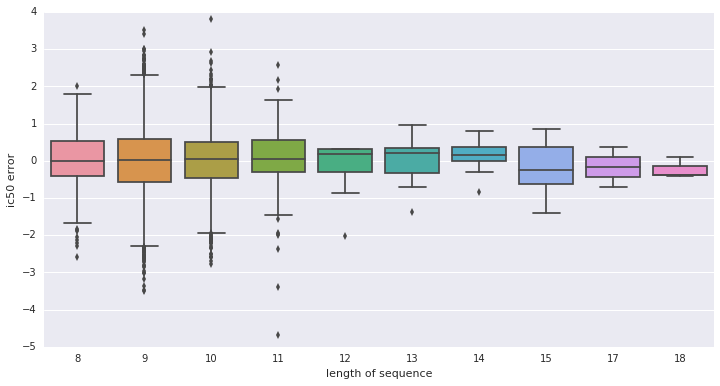

In [7]:
leng=X_test[:,-1]
plt.figure(figsize=(12,6))
sns.boxplot(leng,y_test-y_pred_test)
plt.xlabel('length of sequence')
dump=plt.ylabel('ic50 error')

### Variable importance

In [33]:
importance = bst.get_fscore()

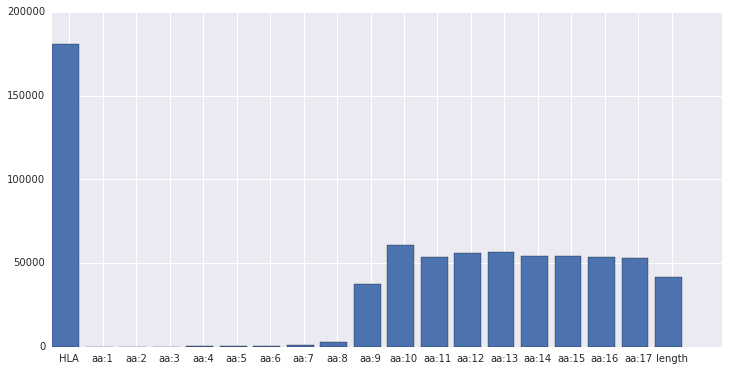

In [35]:
names=['HLA']+['aa:'+str(i) for i in range(1,18,1)]+['length']
keys=sorted([int(key[1:]) for key in importance.keys()])
imp=[importance['f'+str(key)] for key in keys]
    
plt.figure(figsize=(12,6))
plt.bar(range(len(imp)),imp)
dump=plt.xticks(np.arange(len(imp))+0.5,names)